In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
path = 'D:/Dataset/Heart Attack'

# Data Understanding

In [3]:
df = pd.read_csv(path+'/Medicaldataset.csv', sep = ',')
df.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


1. age
2. gender
3. heart rate
4. systolic blood pressure
5. diastolic blood pressure
6. blood sugar (Glukosa)
7. ck-mb (Creatine Kinase MB)
8. troponin (Protein yang ditemukan pada otot jantung)
9. Result (Negatif rentan terkena serangan jantung dan Positif rentan terkena serangan jantung)

In [5]:
df.describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


Terdapat beberapa feature yang memiliki nilai-nilai yang tersebar (tidak terpusat) yaitu CK-MB dan Troponin. Untuk data Blood Sugar akan dirubah dengan aturan jika > 120 akan diberi nilai 1 dan jika tidak akan diberi nilai 0 (berdasarkan sumber data yang dilakukan oleh University of Kurdistan Hewler pada rumah sakit Zheen hospital in Erbil, Iraq), sedangkan untuk Gender tidak termasuk dikarenakan data tersebut bersifat kategorik numerik. Pada tahapan ini apakah terdapat nilai outlier dengan mengecek distribusi data pada feature yang dicurigai dengan rumus Rice Rule

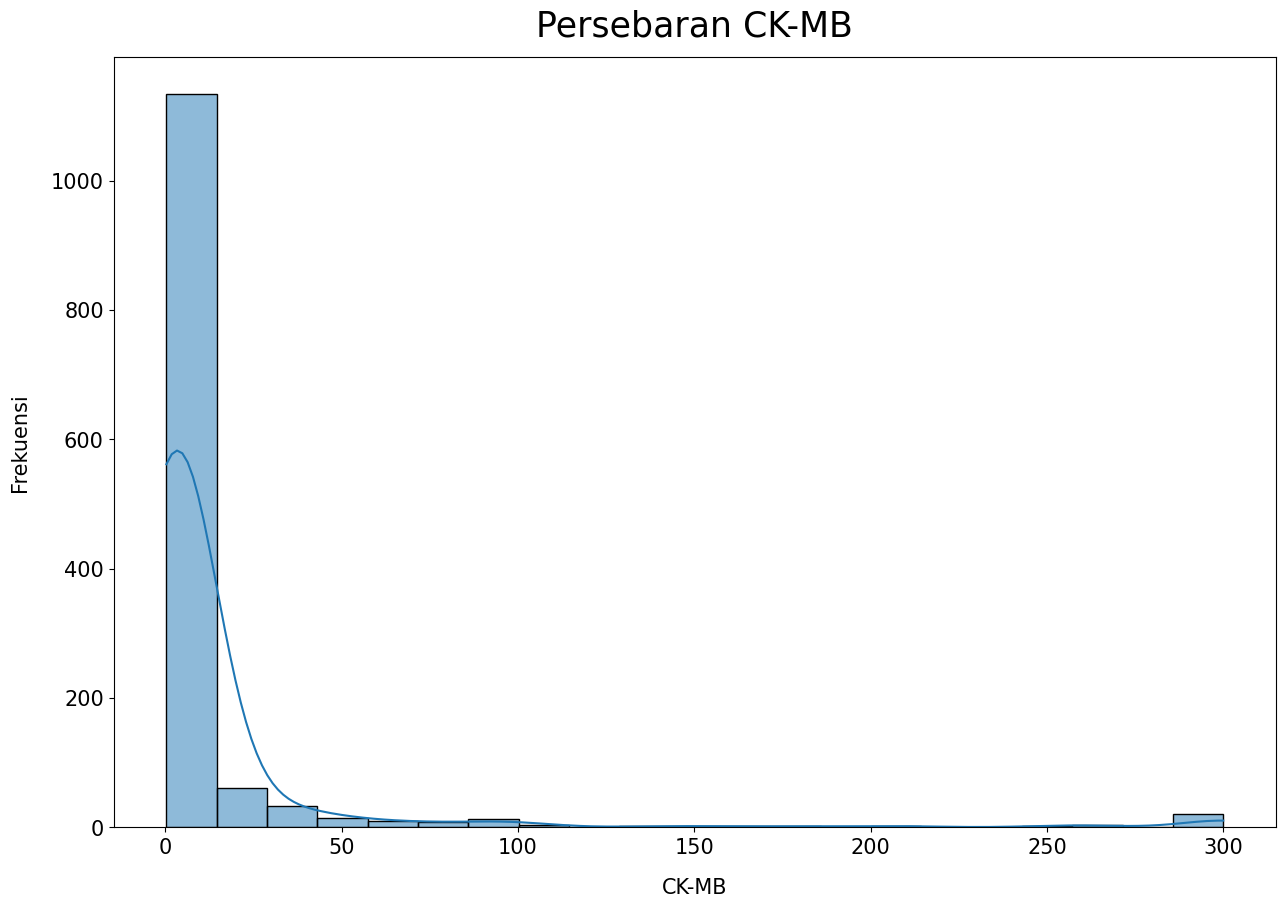

In [6]:
plt.figure(figsize=(15,10))
bins_width = (2 * (np.power(len(df['CK-MB']),1/3)))
sns.histplot(data = df['CK-MB'], bins = int(bins_width), kde = True)
plt.title('Persebaran CK-MB', fontsize = 25, pad = 15)
plt.xlabel('CK-MB', fontsize = 15, labelpad = 15)
plt.ylabel('Frekuensi', fontsize = 15, labelpad = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

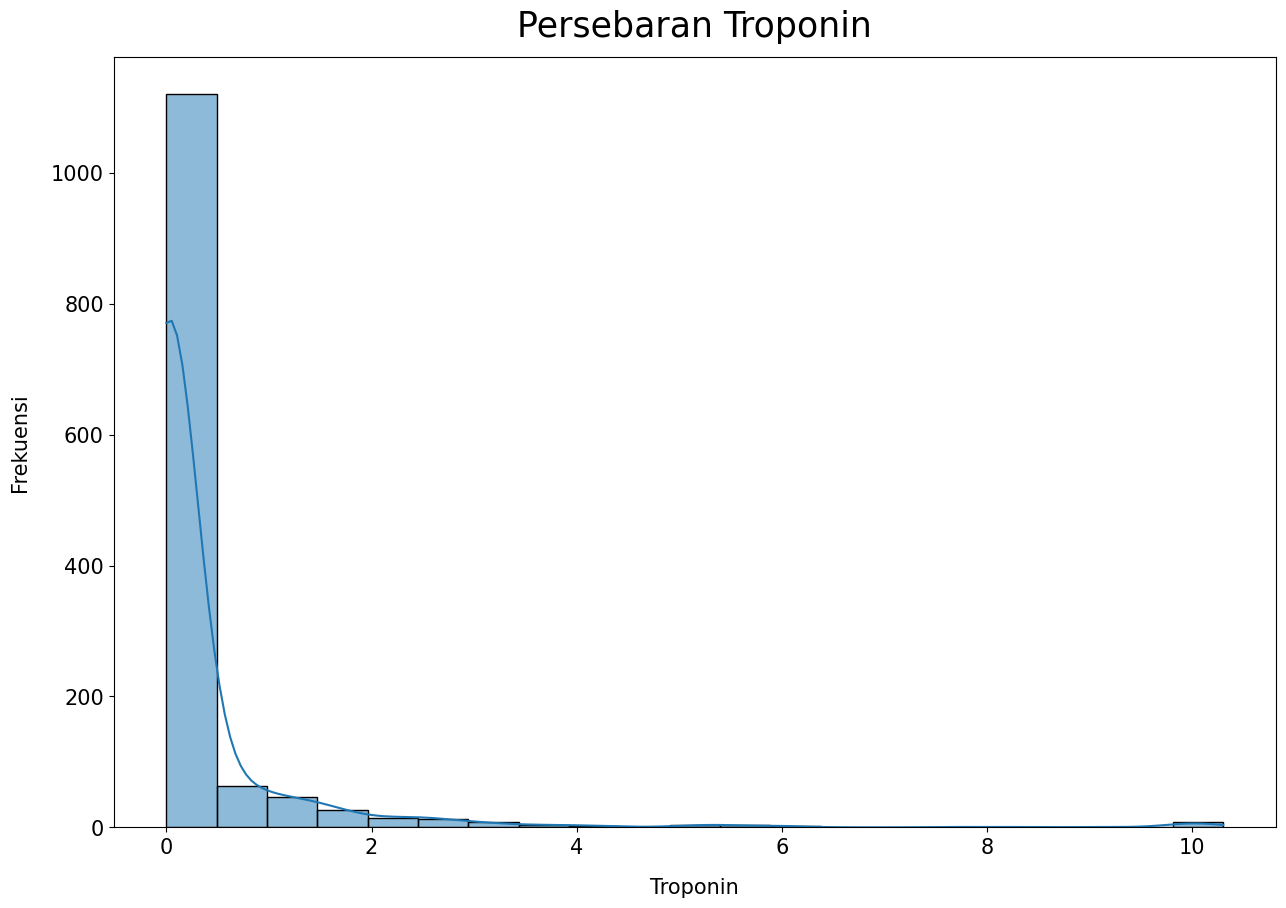

In [7]:
plt.figure(figsize=(15,10))
bins_width = (2 * (np.power(len(df['Troponin']),1/3)))
sns.histplot(data = df['Troponin'], bins = int(bins_width), kde = True)
plt.title('Persebaran Troponin', fontsize = 25, pad = 15)
plt.xlabel('Troponin', fontsize = 15, labelpad = 15)
plt.ylabel('Frekuensi', fontsize = 15, labelpad = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Data Preparation

Berdasarkan persebaran hasil di atas, didapatkan bahwasanya data lebih terpusat ke data yang lebih kecil. 
Hal ini menandakan data bersifat Skewnes Positif yang menandakan bahwasanya terdapat rata-rata nilai CK-MB dan Troponin pasien normal dan hanya sekitar < 50 orang yang memiliki nilai terlalu tinggi.
Rentang normal CK-MB dan Triponin
1. CK-MB Normal = 5–25
2. Troponin = 0–0.04

Hal ini mengindikasikan terdapat sebuah outlier. Namun disini outlier tidak dihapus, hal tersebut dikarenakan untuk memperkuat kenyataan antara nilai yang bersifat normal menjadi tidak normal. Namun untuk mengatasi hal tersebut disini menggunakan metode normalisasi Z-score untuk membuat distribusi menjadi normal
1. Cek dan Remove Outliers Z-Score with MAD
2. Transformasi pada Blood Sugar
3. Normalisasi Min Max
4. LabelEncoder
5. Split Data

## Cek dan Remove Outliers Z-Score with MAD

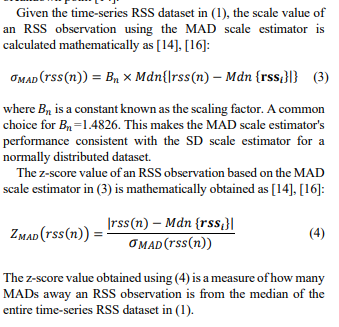

In [8]:
df_cek = df.copy()

In [9]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """
    median = np.median(data, axis = 0)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med), axis = 0)
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

In [10]:
mod_zscore_goals, mad_goals = modified_zscore(df_cek[['Heart rate', 'Systolic blood pressure','Diastolic blood pressure', 'CK-MB', 'Troponin']])
mod_zscore_goals, mad_goals

(array([[-4.90538734e-01,  1.51760421e+00,  8.24377595e-01,
         -4.75312280e-01, -1.22634684e-01],
        [ 1.22634684e+00, -1.09604748e+00, -1.94852886e+00,
          1.76544561e+00,  6.41379395e+01],
        [-6.13173418e-01,  1.51760421e+00,  3.74717089e-01,
         -3.89303391e-01, -6.74490759e-01],
        ...,
        [ 6.74490759e-01,  1.85484959e+00,  2.39818937e+00,
         -7.28812163e-01,  2.59740260e+02],
        [-9.81077468e-01, -2.95089707e-01, -2.99773671e-01,
          1.33540117e+00,  2.11544829e+01],
        [ 1.22634684e+00,  1.39113719e+00,  5.24603924e-01,
          2.17466685e+01,  1.07673252e+02]]),
 array([1.10e+01, 1.60e+01, 9.00e+00, 1.49e+00, 1.10e-02]))

In [11]:
df_cek['mod_zscore'] = np.mean(mod_zscore_goals, axis = 1)

In [12]:
def plot_outliers_data(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)
    total_outliers = np.sum(mask_outliers)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='Outliers')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='Normal')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.text(0.25, 0.95, f'Total data outliers: {total_outliers}', transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. Outliers', fontweight='bold')
    plt.xlabel('Data')
    plt.ylabel('Modified z-score')
    plt.show()

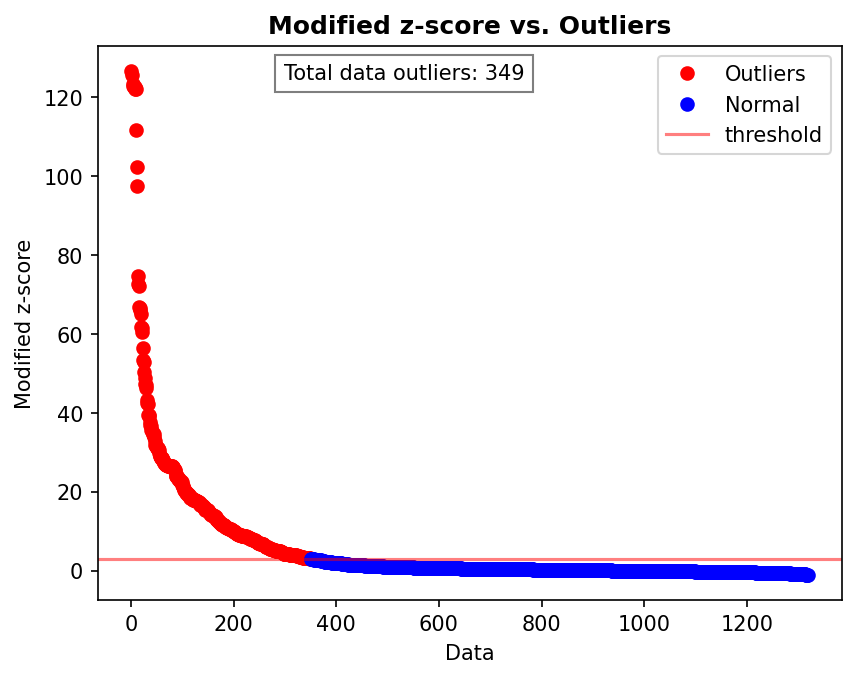

In [13]:
plot_outliers_data(df_cek['mod_zscore'],3)

In [14]:
df_non_outliers = df_cek[~(df_cek['mod_zscore'] > 3)]
df_non_outliers

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result,mod_zscore
0,64,1,66,160,83,160.0,1.80,0.012,negative,0.250699
2,55,1,64,160,77,270.0,1.99,0.003,negative,0.043071
3,64,1,70,120,55,270.0,13.87,0.122,positive,1.984572
4,55,1,64,112,65,300.0,1.08,0.003,negative,-0.623875
5,58,0,61,112,58,87.0,1.83,0.004,negative,-0.685421
...,...,...,...,...,...,...,...,...,...,...
1311,85,1,112,115,69,114.0,2.19,0.062,positive,0.874058
1312,48,1,84,118,68,96.0,5.33,0.006,negative,0.138514
1313,86,0,40,179,68,147.0,5.22,0.011,negative,0.164579
1314,44,1,94,122,67,204.0,1.63,0.006,negative,-0.055098


In [15]:
df_non_outliers.describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,mod_zscore
count,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000
mean,55.346392,0.631959,75.609278,126.392784,71.909278,146.196598,4.473825,0.024199,0.310638
std,13.750827,0.482521,14.926062,25.673454,14.080779,76.314061,5.565044,0.039838,0.765477
min,14.000000,0.000000,20.000000,65.000000,38.000000,35.000000,0.321000,0.001000,-1.098189
25%,45.000000,0.000000,63.000000,110.000000,61.000000,97.000000,1.632500,0.005000,-0.203361
50%,56.000000,1.000000,74.000000,124.000000,71.000000,114.500000,2.680000,0.009000,0.169668
75%,65.000000,1.000000,84.000000,142.000000,80.000000,169.750000,4.667500,0.023000,0.666487
max,91.000000,1.000000,135.000000,223.000000,154.000000,541.000000,43.060000,0.298000,2.997392


## Transformasi pada Blood Sugar

In [16]:
df_non_outliers.drop(columns = 'mod_zscore', axis = 0, inplace = True)
df_non_outliers.reset_index(drop = True).head()

C:\Users\MSI-GAMING\AppData\Local\Temp\ipykernel_10028\3265562991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_outliers.drop(columns = 'mod_zscore', axis = 0, inplace = True)


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,55,1,64,160,77,270.0,1.99,0.003,negative
2,64,1,70,120,55,270.0,13.87,0.122,positive
3,55,1,64,112,65,300.0,1.08,0.003,negative
4,58,0,61,112,58,87.0,1.83,0.004,negative


In [17]:
df_non_outliers['Blood sugar'] = [1 if x > 120 else 0 for x in df_non_outliers['Blood sugar']]
df_non_outliers

C:\Users\MSI-GAMING\AppData\Local\Temp\ipykernel_10028\4291218768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_outliers['Blood sugar'] = [1 if x > 120 else 0 for x in df_non_outliers['Blood sugar']]


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,1,1.80,0.012,negative
2,55,1,64,160,77,1,1.99,0.003,negative
3,64,1,70,120,55,1,13.87,0.122,positive
4,55,1,64,112,65,1,1.08,0.003,negative
5,58,0,61,112,58,0,1.83,0.004,negative
...,...,...,...,...,...,...,...,...,...
1311,85,1,112,115,69,0,2.19,0.062,positive
1312,48,1,84,118,68,0,5.33,0.006,negative
1313,86,0,40,179,68,1,5.22,0.011,negative
1314,44,1,94,122,67,1,1.63,0.006,negative


## Normalisasi Min Max

In [18]:
df_non_outliers.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,1,1.80,0.012,negative
2,55,1,64,160,77,1,1.99,0.003,negative
3,64,1,70,120,55,1,13.87,0.122,positive
4,55,1,64,112,65,1,1.08,0.003,negative
5,58,0,61,112,58,0,1.83,0.004,negative


In [19]:
df_non_outliers.columns

Index(['Age', 'Gender', 'Heart rate', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin',
       'Result'],
      dtype='object')

In [20]:
normalisasi = MinMaxScaler()
normalisasi.fit(df_non_outliers[['Age', 'Heart rate', 'Systolic blood pressure',
                                 'Diastolic blood pressure', 'CK-MB', 'Troponin']])
df_non_outliers[['Age', 'Heart rate', 
                 'Systolic blood pressure','Diastolic blood pressure', 'CK-MB', 'Troponin']] = normalisasi.fit_transform(df_non_outliers[['Age', 'Heart rate', 'Systolic blood pressure',
                                                                                                                                'Diastolic blood pressure', 'CK-MB', 'Troponin']])

C:\Users\MSI-GAMING\AppData\Local\Temp\ipykernel_10028\4219272443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_outliers[['Age', 'Heart rate',


In [21]:
df_non_outliers.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,0.649351,1,0.400000,0.601266,0.387931,1,0.034605,0.037037,negative
2,0.532468,1,0.382609,0.601266,0.336207,1,0.039051,0.006734,negative
3,0.649351,1,0.434783,0.348101,0.146552,1,0.317017,0.407407,positive
4,0.532468,1,0.382609,0.297468,0.232759,1,0.017759,0.006734,negative
5,0.571429,0,0.356522,0.297468,0.172414,0,0.035307,0.010101,negative


## Label Encoder

In [22]:
encoder = LabelEncoder()
df_non_outliers['Result'] = encoder.fit_transform(df_non_outliers['Result'])
df_non_outliers

C:\Users\MSI-GAMING\AppData\Local\Temp\ipykernel_10028\3037175797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_outliers['Result'] = encoder.fit_transform(df_non_outliers['Result'])


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,0.649351,1,0.400000,0.601266,0.387931,1,0.034605,0.037037,0
2,0.532468,1,0.382609,0.601266,0.336207,1,0.039051,0.006734,0
3,0.649351,1,0.434783,0.348101,0.146552,1,0.317017,0.407407,1
4,0.532468,1,0.382609,0.297468,0.232759,1,0.017759,0.006734,0
5,0.571429,0,0.356522,0.297468,0.172414,0,0.035307,0.010101,0
...,...,...,...,...,...,...,...,...,...
1311,0.922078,1,0.800000,0.316456,0.267241,0,0.043731,0.205387,1
1312,0.441558,1,0.556522,0.335443,0.258621,0,0.117200,0.016835,0
1313,0.935065,0,0.173913,0.721519,0.258621,1,0.114626,0.033670,0
1314,0.389610,1,0.643478,0.360759,0.250000,1,0.030628,0.016835,0


In [23]:
encoder_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
encoder_mapping

{'negative': 0, 'positive': 1}

## Split Data

In [24]:
X = df_non_outliers.iloc[:,0:-1]
y = df_non_outliers.iloc[:,-1]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [26]:
print(X_train, y_train)

           Age  Gender  Heart rate  Systolic blood pressure   
994   0.441558       1    0.356522                 0.297468  \
250   0.792208       1    0.391304                 0.265823   
1285  0.467532       0    0.869565                 0.981013   
768   0.571429       1    0.347826                 0.575949   
608   0.467532       1    0.391304                 0.259494   
...        ...     ...         ...                      ...   
146   0.597403       0    0.600000                 0.189873   
346   0.597403       1    0.991304                 0.291139   
1170  0.376623       1    0.521739                 0.000000   
586   0.597403       1    0.678261                 0.500000   
140   0.402597       0    0.513043                 0.139241   

      Diastolic blood pressure  Blood sugar     CK-MB  Troponin  
994                   0.172414            0  0.737710  0.037037  
250                   0.163793            1  0.030862  0.026936  
1285                  0.775862            0  

In [27]:
X_train.to_csv('hasil processing/x_train.csv')
X_test.to_csv('hasil processing/x_test.csv')
y_train.to_csv('hasil processing/y_train.csv')
y_test.to_csv('hasil processing/y_test.csv')